## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold=0.90):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}
    curr_lr = optimizer.param_groups[0]['lr']
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None
    acc_threshold = 0.65
    pseudo_threshold = 0.9

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi and best_acc > acc_threshold:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, pseudo_threshold)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, lr = {curr_lr}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, lr = {curr_lr}")

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())
        history["lr"].append(curr_lr)

        # Update scheduler for learning rate.
        scheduler.step(valid_loss)

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") > float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        if epoch - best_epoch > 50:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
model = torchvision.models.efficientnet_v2_l(weights="IMAGENET1K_V1").to(device)
# model_path = "model/name/path.pth"
# model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=1e-3)

# The number of training epochs.
n_epochs = 1000

# Whether to do semi-supervised learning.
# do_semi = False
do_semi = True

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}


In [12]:
bestd_model, train_history = train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 001/1000 ] loss = 3.07325, acc = 0.23567, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/1000 ] loss = 1.38952, acc = 0.56349, lr = 0.0003


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 002/1000 ] loss = 1.68624, acc = 0.45440, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/1000 ] loss = 0.79427, acc = 0.72569, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

[ Train | 003/1000 ] loss = 1.32020, acc = 0.58583, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/1000 ] loss = 0.69866, acc = 0.78720, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[ Train | 004/1000 ] loss = 1.22887, acc = 0.62279, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/1000 ] loss = 0.67394, acc = 0.77232, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

[ Train | 005/1000 ] loss = 1.10802, acc = 0.65681, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/1000 ] loss = 0.72834, acc = 0.77381, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

[ Train | 006/1000 ] loss = 1.06539, acc = 0.67844, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/1000 ] loss = 0.77507, acc = 0.73611, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

[ Train | 007/1000 ] loss = 0.95849, acc = 0.70475, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/1000 ] loss = 0.61908, acc = 0.79911, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

[ Train | 008/1000 ] loss = 0.90014, acc = 0.72061, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/1000 ] loss = 0.51915, acc = 0.81300, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

[ Train | 009/1000 ] loss = 0.90978, acc = 0.72091, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/1000 ] loss = 0.55020, acc = 0.81250, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

[ Train | 010/1000 ] loss = 0.86976, acc = 0.73408, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/1000 ] loss = 0.63386, acc = 0.78671, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

[ Train | 011/1000 ] loss = 0.84557, acc = 0.74107, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/1000 ] loss = 0.48670, acc = 0.84077, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

[ Train | 012/1000 ] loss = 0.79791, acc = 0.75379, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/1000 ] loss = 0.49580, acc = 0.84970, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

[ Train | 013/1000 ] loss = 0.80447, acc = 0.75506, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/1000 ] loss = 0.54990, acc = 0.82391, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

[ Train | 014/1000 ] loss = 0.79175, acc = 0.75898, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/1000 ] loss = 0.46402, acc = 0.83234, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

[ Train | 015/1000 ] loss = 0.78737, acc = 0.75818, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/1000 ] loss = 0.49411, acc = 0.83185, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

[ Train | 016/1000 ] loss = 0.74899, acc = 0.76401, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/1000 ] loss = 0.53096, acc = 0.83333, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

[ Train | 017/1000 ] loss = 0.74885, acc = 0.76745, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/1000 ] loss = 0.54492, acc = 0.82192, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

[ Train | 018/1000 ] loss = 0.68769, acc = 0.79054, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/1000 ] loss = 0.54201, acc = 0.82143, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

[ Train | 019/1000 ] loss = 0.69496, acc = 0.78472, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/1000 ] loss = 0.46962, acc = 0.84772, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

[ Train | 020/1000 ] loss = 0.65307, acc = 0.79131, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/1000 ] loss = 0.49445, acc = 0.84276, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

[ Train | 021/1000 ] loss = 0.64724, acc = 0.79647, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/1000 ] loss = 0.43943, acc = 0.86260, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 022/1000 ] loss = 0.63351, acc = 0.80521, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/1000 ] loss = 0.42199, acc = 0.87004, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 023/1000 ] loss = 0.63127, acc = 0.80365, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/1000 ] loss = 0.46848, acc = 0.86210, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

[ Train | 024/1000 ] loss = 0.62590, acc = 0.80635, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/1000 ] loss = 0.44512, acc = 0.85615, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

[ Train | 025/1000 ] loss = 0.60410, acc = 0.81216, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/1000 ] loss = 0.46259, acc = 0.84722, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[ Train | 026/1000 ] loss = 0.58899, acc = 0.81567, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/1000 ] loss = 0.38121, acc = 0.86954, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

[ Train | 027/1000 ] loss = 0.60639, acc = 0.81123, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/1000 ] loss = 0.36462, acc = 0.88492, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[ Train | 028/1000 ] loss = 0.58738, acc = 0.81967, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/1000 ] loss = 0.39643, acc = 0.86756, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[ Train | 029/1000 ] loss = 0.58833, acc = 0.82000, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/1000 ] loss = 0.45170, acc = 0.85764, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[ Train | 030/1000 ] loss = 0.59646, acc = 0.81783, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/1000 ] loss = 0.37992, acc = 0.86806, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

[ Train | 031/1000 ] loss = 0.59138, acc = 0.81282, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/1000 ] loss = 0.41121, acc = 0.86111, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

[ Train | 032/1000 ] loss = 0.56944, acc = 0.82633, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/1000 ] loss = 0.38881, acc = 0.86657, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[ Train | 033/1000 ] loss = 0.56830, acc = 0.82533, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/1000 ] loss = 0.37657, acc = 0.87798, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

[ Train | 034/1000 ] loss = 0.52337, acc = 0.83899, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/1000 ] loss = 0.38229, acc = 0.88542, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

[ Train | 035/1000 ] loss = 0.52911, acc = 0.83465, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/1000 ] loss = 0.41327, acc = 0.86508, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

[ Train | 036/1000 ] loss = 0.53872, acc = 0.83547, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/1000 ] loss = 0.37470, acc = 0.87599, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

[ Train | 037/1000 ] loss = 0.51795, acc = 0.83647, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/1000 ] loss = 0.40968, acc = 0.87054, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

[ Train | 038/1000 ] loss = 0.50769, acc = 0.84431, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/1000 ] loss = 0.38898, acc = 0.87450, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

[ Train | 039/1000 ] loss = 0.50082, acc = 0.84691, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/1000 ] loss = 0.40110, acc = 0.88393, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

[ Train | 040/1000 ] loss = 0.48856, acc = 0.84555, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/1000 ] loss = 0.35632, acc = 0.88690, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

[ Train | 041/1000 ] loss = 0.48708, acc = 0.84988, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/1000 ] loss = 0.36515, acc = 0.87649, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

[ Train | 042/1000 ] loss = 0.47920, acc = 0.85049, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/1000 ] loss = 0.37732, acc = 0.88740, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

[ Train | 043/1000 ] loss = 0.45690, acc = 0.85601, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/1000 ] loss = 0.42105, acc = 0.87103, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

[ Train | 044/1000 ] loss = 0.48423, acc = 0.84952, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/1000 ] loss = 0.36920, acc = 0.88244, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

[ Train | 045/1000 ] loss = 0.43316, acc = 0.86458, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/1000 ] loss = 0.35040, acc = 0.87351, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

[ Train | 046/1000 ] loss = 0.47815, acc = 0.85446, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/1000 ] loss = 0.36729, acc = 0.87252, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

[ Train | 047/1000 ] loss = 0.44827, acc = 0.86127, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/1000 ] loss = 0.36640, acc = 0.88145, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

[ Train | 048/1000 ] loss = 0.44787, acc = 0.86305, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/1000 ] loss = 0.32700, acc = 0.89087, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

[ Train | 049/1000 ] loss = 0.45454, acc = 0.85974, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/1000 ] loss = 0.36577, acc = 0.87847, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

[ Train | 050/1000 ] loss = 0.41870, acc = 0.86698, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/1000 ] loss = 0.35609, acc = 0.88690, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

[ Train | 051/1000 ] loss = 0.42701, acc = 0.86519, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/1000 ] loss = 0.36454, acc = 0.87599, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

[ Train | 052/1000 ] loss = 0.46578, acc = 0.85505, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/1000 ] loss = 0.40509, acc = 0.87252, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

[ Train | 053/1000 ] loss = 0.43676, acc = 0.86616, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/1000 ] loss = 0.38666, acc = 0.86161, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

[ Train | 054/1000 ] loss = 0.44023, acc = 0.86295, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/1000 ] loss = 0.38171, acc = 0.88790, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

[ Train | 055/1000 ] loss = 0.40240, acc = 0.87515, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/1000 ] loss = 0.35172, acc = 0.88641, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

[ Train | 056/1000 ] loss = 0.41535, acc = 0.87109, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/1000 ] loss = 0.34034, acc = 0.88740, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

[ Train | 057/1000 ] loss = 0.40746, acc = 0.87589, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/1000 ] loss = 0.34007, acc = 0.89187, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

[ Train | 058/1000 ] loss = 0.43277, acc = 0.86684, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/1000 ] loss = 0.34841, acc = 0.88542, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

[ Train | 059/1000 ] loss = 0.39767, acc = 0.88170, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/1000 ] loss = 0.36085, acc = 0.88393, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

[ Train | 060/1000 ] loss = 0.41315, acc = 0.87284, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/1000 ] loss = 0.37050, acc = 0.87748, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

[ Train | 061/1000 ] loss = 0.39999, acc = 0.87814, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/1000 ] loss = 0.37258, acc = 0.87946, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

[ Train | 062/1000 ] loss = 0.37174, acc = 0.88492, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/1000 ] loss = 0.36122, acc = 0.88542, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

[ Train | 063/1000 ] loss = 0.38277, acc = 0.88442, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/1000 ] loss = 0.33411, acc = 0.88889, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

[ Train | 064/1000 ] loss = 0.37724, acc = 0.88421, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/1000 ] loss = 0.39698, acc = 0.87748, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

[ Train | 065/1000 ] loss = 0.38260, acc = 0.88049, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/1000 ] loss = 0.37954, acc = 0.88889, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

[ Train | 066/1000 ] loss = 0.37437, acc = 0.88960, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 066/1000 ] loss = 0.36761, acc = 0.88690, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

[ Train | 067/1000 ] loss = 0.35200, acc = 0.89144, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 067/1000 ] loss = 0.35883, acc = 0.88542, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

[ Train | 068/1000 ] loss = 0.36707, acc = 0.88903, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 068/1000 ] loss = 0.35512, acc = 0.88690, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[ Train | 069/1000 ] loss = 0.34631, acc = 0.89248, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 069/1000 ] loss = 0.37822, acc = 0.87798, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

[ Train | 070/1000 ] loss = 0.35827, acc = 0.88907, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 070/1000 ] loss = 0.32013, acc = 0.89087, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[ Train | 071/1000 ] loss = 0.34269, acc = 0.89485, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 071/1000 ] loss = 0.36166, acc = 0.88889, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[ Train | 072/1000 ] loss = 0.33428, acc = 0.89444, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 072/1000 ] loss = 0.37385, acc = 0.88641, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

[ Train | 073/1000 ] loss = 0.35358, acc = 0.89361, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 073/1000 ] loss = 0.35569, acc = 0.88889, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

[ Train | 074/1000 ] loss = 0.36279, acc = 0.88769, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 074/1000 ] loss = 0.35200, acc = 0.89137, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

[ Train | 075/1000 ] loss = 0.35134, acc = 0.89238, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 075/1000 ] loss = 0.37084, acc = 0.89137, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

[ Train | 076/1000 ] loss = 0.33611, acc = 0.89992, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 076/1000 ] loss = 0.34936, acc = 0.88988, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

[ Train | 077/1000 ] loss = 0.32705, acc = 0.90204, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 077/1000 ] loss = 0.34756, acc = 0.89484, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

[ Train | 078/1000 ] loss = 0.35325, acc = 0.89529, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 078/1000 ] loss = 0.33002, acc = 0.89385, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

[ Train | 079/1000 ] loss = 0.31544, acc = 0.90139, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 079/1000 ] loss = 0.34047, acc = 0.89484, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

[ Train | 080/1000 ] loss = 0.32128, acc = 0.90060, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 080/1000 ] loss = 0.33800, acc = 0.89732, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

[ Train | 081/1000 ] loss = 0.34646, acc = 0.89570, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 081/1000 ] loss = 0.32698, acc = 0.89484, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

[ Train | 082/1000 ] loss = 0.30610, acc = 0.90535, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 082/1000 ] loss = 0.32672, acc = 0.89732, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

[ Train | 083/1000 ] loss = 0.33202, acc = 0.89759, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 083/1000 ] loss = 0.30226, acc = 0.89931, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

[ Train | 084/1000 ] loss = 0.31929, acc = 0.90269, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 084/1000 ] loss = 0.32294, acc = 0.89633, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

[ Train | 085/1000 ] loss = 0.29706, acc = 0.91091, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 085/1000 ] loss = 0.32872, acc = 0.89534, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 086/1000 ] loss = 0.30510, acc = 0.90497, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 086/1000 ] loss = 0.33000, acc = 0.89137, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 087/1000 ] loss = 0.30972, acc = 0.90578, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 087/1000 ] loss = 0.28960, acc = 0.89683, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

[ Train | 088/1000 ] loss = 0.31222, acc = 0.90652, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 088/1000 ] loss = 0.31386, acc = 0.90129, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

[ Train | 089/1000 ] loss = 0.31770, acc = 0.90398, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 089/1000 ] loss = 0.30947, acc = 0.90526, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

[ Train | 090/1000 ] loss = 0.30049, acc = 0.91272, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 090/1000 ] loss = 0.30399, acc = 0.90327, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

[ Train | 091/1000 ] loss = 0.32839, acc = 0.90184, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 091/1000 ] loss = 0.30197, acc = 0.90079, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 092/1000 ] loss = 0.30815, acc = 0.90390, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 092/1000 ] loss = 0.29047, acc = 0.89980, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

[ Train | 093/1000 ] loss = 0.30190, acc = 0.91085, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 093/1000 ] loss = 0.29622, acc = 0.89782, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 094/1000 ] loss = 0.29056, acc = 0.91223, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 094/1000 ] loss = 0.28244, acc = 0.90278, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 095/1000 ] loss = 0.30477, acc = 0.90857, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 095/1000 ] loss = 0.28091, acc = 0.90179, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

[ Train | 096/1000 ] loss = 0.31151, acc = 0.90517, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 096/1000 ] loss = 0.29508, acc = 0.89435, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

[ Train | 097/1000 ] loss = 0.30547, acc = 0.90825, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 097/1000 ] loss = 0.28890, acc = 0.90179, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 098/1000 ] loss = 0.29825, acc = 0.90995, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 098/1000 ] loss = 0.30048, acc = 0.89633, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 099/1000 ] loss = 0.28872, acc = 0.91415, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 099/1000 ] loss = 0.28616, acc = 0.90774, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 100/1000 ] loss = 0.29249, acc = 0.91090, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 100/1000 ] loss = 0.30375, acc = 0.89980, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 101/1000 ] loss = 0.28009, acc = 0.91547, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 101/1000 ] loss = 0.29568, acc = 0.90774, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 102/1000 ] loss = 0.30751, acc = 0.90467, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 102/1000 ] loss = 0.29270, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

[ Train | 103/1000 ] loss = 0.26034, acc = 0.92067, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 103/1000 ] loss = 0.29859, acc = 0.90873, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 104/1000 ] loss = 0.27018, acc = 0.91746, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 104/1000 ] loss = 0.30088, acc = 0.90526, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 105/1000 ] loss = 0.31747, acc = 0.90356, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 105/1000 ] loss = 0.30104, acc = 0.90774, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 106/1000 ] loss = 0.28150, acc = 0.91720, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 106/1000 ] loss = 0.30474, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 107/1000 ] loss = 0.27741, acc = 0.91401, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 107/1000 ] loss = 0.29867, acc = 0.91667, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 108/1000 ] loss = 0.28426, acc = 0.91195, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 108/1000 ] loss = 0.30579, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 109/1000 ] loss = 0.28471, acc = 0.91324, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 109/1000 ] loss = 0.28298, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 110/1000 ] loss = 0.26710, acc = 0.91825, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 110/1000 ] loss = 0.28679, acc = 0.91270, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 111/1000 ] loss = 0.27796, acc = 0.91706, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 111/1000 ] loss = 0.30615, acc = 0.90625, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 112/1000 ] loss = 0.27029, acc = 0.92023, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 112/1000 ] loss = 0.29637, acc = 0.91369, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 113/1000 ] loss = 0.28482, acc = 0.91536, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 113/1000 ] loss = 0.28526, acc = 0.91667, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 114/1000 ] loss = 0.26904, acc = 0.91929, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 114/1000 ] loss = 0.29890, acc = 0.91121, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 115/1000 ] loss = 0.26806, acc = 0.91902, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 115/1000 ] loss = 0.29658, acc = 0.90575, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 116/1000 ] loss = 0.26972, acc = 0.91996, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 116/1000 ] loss = 0.28960, acc = 0.91369, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 117/1000 ] loss = 0.27120, acc = 0.91654, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 117/1000 ] loss = 0.29986, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 118/1000 ] loss = 0.27432, acc = 0.91771, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 118/1000 ] loss = 0.30099, acc = 0.90427, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 119/1000 ] loss = 0.27782, acc = 0.91640, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 119/1000 ] loss = 0.30407, acc = 0.90129, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 120/1000 ] loss = 0.26455, acc = 0.92174, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 120/1000 ] loss = 0.30864, acc = 0.90377, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 121/1000 ] loss = 0.27815, acc = 0.91588, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 121/1000 ] loss = 0.31173, acc = 0.90625, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 122/1000 ] loss = 0.28637, acc = 0.91471, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 122/1000 ] loss = 0.29574, acc = 0.90327, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 123/1000 ] loss = 0.26180, acc = 0.91981, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 123/1000 ] loss = 0.30228, acc = 0.90377, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 124/1000 ] loss = 0.27123, acc = 0.92047, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 124/1000 ] loss = 0.31608, acc = 0.90079, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 125/1000 ] loss = 0.25854, acc = 0.92112, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 125/1000 ] loss = 0.30081, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 126/1000 ] loss = 0.27676, acc = 0.91512, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 126/1000 ] loss = 0.31146, acc = 0.89782, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 127/1000 ] loss = 0.25665, acc = 0.92057, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 127/1000 ] loss = 0.29317, acc = 0.90476, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 128/1000 ] loss = 0.26274, acc = 0.91990, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 128/1000 ] loss = 0.29436, acc = 0.89931, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 129/1000 ] loss = 0.25273, acc = 0.92107, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 129/1000 ] loss = 0.29460, acc = 0.90625, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 130/1000 ] loss = 0.23576, acc = 0.92734, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 130/1000 ] loss = 0.30113, acc = 0.89980, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 131/1000 ] loss = 0.26030, acc = 0.91654, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 131/1000 ] loss = 0.29773, acc = 0.90526, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 132/1000 ] loss = 0.26397, acc = 0.91977, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 132/1000 ] loss = 0.29654, acc = 0.90427, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 133/1000 ] loss = 0.26407, acc = 0.92158, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 133/1000 ] loss = 0.29838, acc = 0.90476, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 134/1000 ] loss = 0.24016, acc = 0.92643, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 134/1000 ] loss = 0.28258, acc = 0.90823, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 135/1000 ] loss = 0.26513, acc = 0.92042, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 135/1000 ] loss = 0.28500, acc = 0.90823, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 136/1000 ] loss = 0.25895, acc = 0.92365, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 136/1000 ] loss = 0.28291, acc = 0.90476, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 137/1000 ] loss = 0.24538, acc = 0.92361, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 137/1000 ] loss = 0.29285, acc = 0.90476, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 138/1000 ] loss = 0.26377, acc = 0.91973, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 138/1000 ] loss = 0.28310, acc = 0.91220, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 139/1000 ] loss = 0.25364, acc = 0.92430, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 139/1000 ] loss = 0.27936, acc = 0.91419, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 140/1000 ] loss = 0.25644, acc = 0.91821, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 140/1000 ] loss = 0.28844, acc = 0.91319, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 141/1000 ] loss = 0.25995, acc = 0.92076, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 141/1000 ] loss = 0.28993, acc = 0.91369, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 142/1000 ] loss = 0.25690, acc = 0.92464, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 142/1000 ] loss = 0.28721, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 143/1000 ] loss = 0.24698, acc = 0.92580, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 143/1000 ] loss = 0.29447, acc = 0.91319, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 144/1000 ] loss = 0.25522, acc = 0.92370, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 144/1000 ] loss = 0.28393, acc = 0.91319, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 145/1000 ] loss = 0.27102, acc = 0.91860, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 145/1000 ] loss = 0.28320, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 146/1000 ] loss = 0.23841, acc = 0.92961, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 146/1000 ] loss = 0.28971, acc = 0.90774, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 147/1000 ] loss = 0.24194, acc = 0.92870, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 147/1000 ] loss = 0.27550, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 148/1000 ] loss = 0.24699, acc = 0.92451, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 148/1000 ] loss = 0.27917, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 149/1000 ] loss = 0.25748, acc = 0.92207, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 149/1000 ] loss = 0.27607, acc = 0.90526, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 150/1000 ] loss = 0.26347, acc = 0.92104, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 150/1000 ] loss = 0.28204, acc = 0.90575, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 151/1000 ] loss = 0.25730, acc = 0.92094, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 151/1000 ] loss = 0.28351, acc = 0.90179, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 152/1000 ] loss = 0.25542, acc = 0.92301, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 152/1000 ] loss = 0.28813, acc = 0.90575, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 153/1000 ] loss = 0.24481, acc = 0.92340, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 153/1000 ] loss = 0.28470, acc = 0.91468, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 154/1000 ] loss = 0.24921, acc = 0.92438, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 154/1000 ] loss = 0.28059, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 155/1000 ] loss = 0.25376, acc = 0.92728, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 155/1000 ] loss = 0.27720, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 156/1000 ] loss = 0.24350, acc = 0.92773, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 156/1000 ] loss = 0.27728, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 157/1000 ] loss = 0.25976, acc = 0.92101, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 157/1000 ] loss = 0.27463, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 158/1000 ] loss = 0.25564, acc = 0.92510, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 158/1000 ] loss = 0.28208, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 159/1000 ] loss = 0.25552, acc = 0.92130, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 159/1000 ] loss = 0.28319, acc = 0.91518, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 160/1000 ] loss = 0.25184, acc = 0.92454, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 160/1000 ] loss = 0.27942, acc = 0.91716, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 161/1000 ] loss = 0.25781, acc = 0.92267, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 161/1000 ] loss = 0.27410, acc = 0.91419, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 162/1000 ] loss = 0.24396, acc = 0.92695, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 162/1000 ] loss = 0.27781, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 163/1000 ] loss = 0.24627, acc = 0.92395, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 163/1000 ] loss = 0.28057, acc = 0.91419, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 164/1000 ] loss = 0.25274, acc = 0.92200, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 164/1000 ] loss = 0.28567, acc = 0.91518, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

[ Train | 165/1000 ] loss = 0.22999, acc = 0.93216, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 165/1000 ] loss = 0.28190, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 166/1000 ] loss = 0.23279, acc = 0.93248, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 166/1000 ] loss = 0.28956, acc = 0.91419, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 167/1000 ] loss = 0.25117, acc = 0.92497, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 167/1000 ] loss = 0.27768, acc = 0.91617, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 168/1000 ] loss = 0.25844, acc = 0.92289, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 168/1000 ] loss = 0.28753, acc = 0.91369, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 169/1000 ] loss = 0.24588, acc = 0.92638, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 169/1000 ] loss = 0.28847, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 170/1000 ] loss = 0.24759, acc = 0.92734, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 170/1000 ] loss = 0.28603, acc = 0.91270, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 171/1000 ] loss = 0.25420, acc = 0.92306, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 171/1000 ] loss = 0.28460, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 172/1000 ] loss = 0.25533, acc = 0.92323, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 172/1000 ] loss = 0.28404, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 173/1000 ] loss = 0.24291, acc = 0.92961, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 173/1000 ] loss = 0.27835, acc = 0.90873, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 174/1000 ] loss = 0.23994, acc = 0.92773, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 174/1000 ] loss = 0.28278, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 175/1000 ] loss = 0.24077, acc = 0.92715, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 175/1000 ] loss = 0.27236, acc = 0.91121, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 176/1000 ] loss = 0.25213, acc = 0.92165, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 176/1000 ] loss = 0.27831, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 177/1000 ] loss = 0.24517, acc = 0.92618, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 177/1000 ] loss = 0.26509, acc = 0.91716, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 178/1000 ] loss = 0.24121, acc = 0.92863, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 178/1000 ] loss = 0.27774, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 179/1000 ] loss = 0.25204, acc = 0.92515, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 179/1000 ] loss = 0.26970, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 180/1000 ] loss = 0.25813, acc = 0.92213, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 180/1000 ] loss = 0.27686, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 181/1000 ] loss = 0.24823, acc = 0.92510, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 181/1000 ] loss = 0.27771, acc = 0.91270, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 182/1000 ] loss = 0.22939, acc = 0.92843, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 182/1000 ] loss = 0.27745, acc = 0.91121, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 183/1000 ] loss = 0.25753, acc = 0.92188, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 183/1000 ] loss = 0.27135, acc = 0.91220, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 184/1000 ] loss = 0.23899, acc = 0.92625, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 184/1000 ] loss = 0.27466, acc = 0.91220, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 185/1000 ] loss = 0.24191, acc = 0.92651, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 185/1000 ] loss = 0.27909, acc = 0.90675, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 186/1000 ] loss = 0.23886, acc = 0.93030, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 186/1000 ] loss = 0.27637, acc = 0.91270, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 187/1000 ] loss = 0.24479, acc = 0.92837, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 187/1000 ] loss = 0.28225, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 188/1000 ] loss = 0.24736, acc = 0.92696, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 188/1000 ] loss = 0.28459, acc = 0.91121, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 189/1000 ] loss = 0.24439, acc = 0.92638, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 189/1000 ] loss = 0.27908, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 190/1000 ] loss = 0.25019, acc = 0.92581, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 190/1000 ] loss = 0.28787, acc = 0.90427, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 191/1000 ] loss = 0.24304, acc = 0.92848, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 191/1000 ] loss = 0.28305, acc = 0.90327, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 192/1000 ] loss = 0.24722, acc = 0.92881, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 192/1000 ] loss = 0.27633, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 193/1000 ] loss = 0.22306, acc = 0.93124, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 193/1000 ] loss = 0.27824, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 194/1000 ] loss = 0.24019, acc = 0.92618, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 194/1000 ] loss = 0.28270, acc = 0.90476, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 195/1000 ] loss = 0.24904, acc = 0.92264, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 195/1000 ] loss = 0.28424, acc = 0.91270, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

[ Train | 196/1000 ] loss = 0.24600, acc = 0.92664, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 196/1000 ] loss = 0.28182, acc = 0.90823, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 197/1000 ] loss = 0.23730, acc = 0.92804, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 197/1000 ] loss = 0.28029, acc = 0.90774, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 198/1000 ] loss = 0.24736, acc = 0.92715, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 198/1000 ] loss = 0.28424, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 199/1000 ] loss = 0.23581, acc = 0.93158, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 199/1000 ] loss = 0.28848, acc = 0.90625, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 200/1000 ] loss = 0.25527, acc = 0.92536, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 200/1000 ] loss = 0.28471, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 201/1000 ] loss = 0.23705, acc = 0.92708, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 201/1000 ] loss = 0.27772, acc = 0.91022, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 202/1000 ] loss = 0.24132, acc = 0.92569, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 202/1000 ] loss = 0.28822, acc = 0.90675, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 203/1000 ] loss = 0.24925, acc = 0.92715, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 203/1000 ] loss = 0.28072, acc = 0.90873, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 204/1000 ] loss = 0.24701, acc = 0.92619, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 204/1000 ] loss = 0.27761, acc = 0.90675, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 205/1000 ] loss = 0.23042, acc = 0.93149, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 205/1000 ] loss = 0.27507, acc = 0.91220, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 206/1000 ] loss = 0.24931, acc = 0.92472, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 206/1000 ] loss = 0.27760, acc = 0.91766, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 207/1000 ] loss = 0.23665, acc = 0.93178, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 207/1000 ] loss = 0.27762, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 208/1000 ] loss = 0.23208, acc = 0.93162, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 208/1000 ] loss = 0.28118, acc = 0.91121, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

[ Train | 209/1000 ] loss = 0.24092, acc = 0.92563, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 209/1000 ] loss = 0.29022, acc = 0.90873, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 210/1000 ] loss = 0.24185, acc = 0.92983, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 210/1000 ] loss = 0.27528, acc = 0.90923, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 211/1000 ] loss = 0.24407, acc = 0.92772, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 211/1000 ] loss = 0.27853, acc = 0.90873, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 212/1000 ] loss = 0.24053, acc = 0.92759, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 212/1000 ] loss = 0.27660, acc = 0.91121, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

[ Train | 213/1000 ] loss = 0.25016, acc = 0.92551, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 213/1000 ] loss = 0.27563, acc = 0.91071, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 214/1000 ] loss = 0.22623, acc = 0.93013, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 214/1000 ] loss = 0.27418, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 215/1000 ] loss = 0.23890, acc = 0.93034, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 215/1000 ] loss = 0.27045, acc = 0.91319, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 216/1000 ] loss = 0.24390, acc = 0.92467, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 216/1000 ] loss = 0.27923, acc = 0.91220, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 217/1000 ] loss = 0.25386, acc = 0.92477, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 217/1000 ] loss = 0.27659, acc = 0.91121, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 218/1000 ] loss = 0.21749, acc = 0.93364, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 218/1000 ] loss = 0.28508, acc = 0.91369, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 219/1000 ] loss = 0.24179, acc = 0.92958, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 219/1000 ] loss = 0.27907, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 220/1000 ] loss = 0.24354, acc = 0.92772, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 220/1000 ] loss = 0.27877, acc = 0.91171, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 221/1000 ] loss = 0.23629, acc = 0.92817, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 221/1000 ] loss = 0.27588, acc = 0.90873, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 222/1000 ] loss = 0.24206, acc = 0.92766, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 222/1000 ] loss = 0.28687, acc = 0.90675, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 223/1000 ] loss = 0.23346, acc = 0.92837, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 223/1000 ] loss = 0.27988, acc = 0.90625, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 224/1000 ] loss = 0.23737, acc = 0.93026, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 224/1000 ] loss = 0.27326, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 225/1000 ] loss = 0.24220, acc = 0.92791, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 225/1000 ] loss = 0.27497, acc = 0.91270, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

[ Train | 226/1000 ] loss = 0.23066, acc = 0.93047, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 226/1000 ] loss = 0.27832, acc = 0.90972, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 227/1000 ] loss = 0.23095, acc = 0.93064, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 227/1000 ] loss = 0.27398, acc = 0.91270, lr = 0.0003


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 228/1000 ] loss = 0.25017, acc = 0.92543, lr = 0.0003


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 228/1000 ] loss = 0.28083, acc = 0.90923, lr = 0.0003


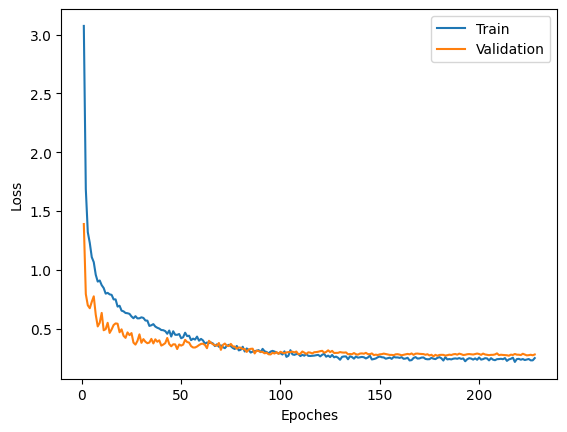

In [13]:
plot_loss(history)


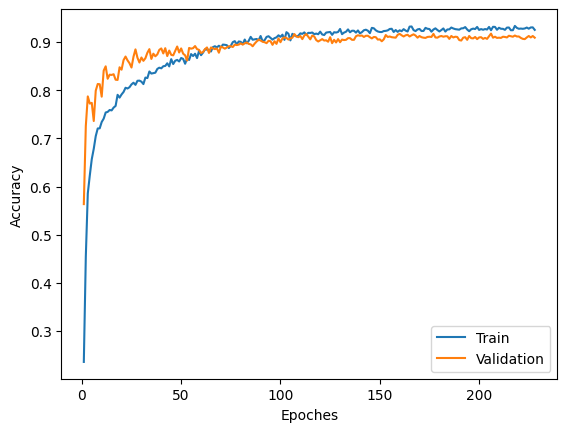

In [14]:
plot_acc(history)


## Testing


In [15]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [16]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
